In [18]:
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

sys.path.append('..')
from src.data import load_data

In [19]:
data_2021 = load_data("../data", "2020")
current_location = data_2021[:, 200, 200]

In [20]:
def compute_flow_rate_over_a_year(panel_size: int, point_data: np.array, panel_yield: float) -> np.array:
    """
    Compute the flow rate over a year for a given panel size.
    panel_size: the size of the panel in m².
    point_data: measures of irradiance for the given point in W/m² sampled every 15 minutes.
    panel_yield: the panel yield.
    returns: the flow rate corresponding to the given power.
    """
    assert panel_size >= 4, "Usually at least 4m² per pump are required"
    assert 0 < panel_yield < 1, "Panel yield must be between 0 and 1"

    panel_output = 1.0 * point_data * panel_size * panel_yield

    power_to_flow_rate_15_min = lambda power: max([(power - 74.5) / (4 * 0.00375), 0])
    return np.vectorize(power_to_flow_rate_15_min)(panel_output)

In [21]:
compute_flow_rate_over_a_year(4, current_location, 0.15)

array([0, 0, 0, ..., 0, 0, 0])

In [22]:
def find_best_harvesting_period(yearly_flow_rate_15_min: np.array)-> tuple[int, int]:
    """
    Returns the best harvesting period for a given flow rate of water sampled every 15 minutes.
    yearly_flow_rate_15_min: flow rate of water sampled every 15 minute
    returns: starting and ending index of the best period
    """
    daily_flow_rate = yearly_flow_rate_15_min.reshape((366, 96)).sum(axis=1)

    # We need to smooth the curve because some days with a lot clouds are adding to much noise
    daily_flow_rate_series = pd.Series(daily_flow_rate)
    daily_flow_rate_trailing_7_days = daily_flow_rate_series.rolling(window=7, min_periods=0).mean()

    # During the growth process we need a one to two month period with 4 times more water than the rest of the year.
    # This period will define when we need to harvest plants
    ROLLING_WINDOW = 60

    minimum_flow_trailing_60_days = daily_flow_rate_trailing_7_days.rolling(window=ROLLING_WINDOW).min().fillna(0)

    best_minimum_flow_rate_over_60_days = minimum_flow_trailing_60_days[ROLLING_WINDOW:].max()

    # We have the maxi now we need days index
    days_with_best_minimum_flow_rate_over_60_days = minimum_flow_trailing_60_days[
        minimum_flow_trailing_60_days == best_minimum_flow_rate_over_60_days].index

    # As the minimum is computed over 60 previous days we subtract the time window
    period_start = days_with_best_minimum_flow_rate_over_60_days[0] - ROLLING_WINDOW
    period_end = days_with_best_minimum_flow_rate_over_60_days[-1]

    fig, ax = plt.subplots(1, 1, figsize=(20, 12))
    fig.suptitle("Smoothed daily flow (L/days) with targeedt harvesting period")
    sns.lineplot(x=range(len(daily_flow_rate_trailing_7_days)), ax=ax, y=daily_flow_rate_trailing_7_days)
    plt.axvline(x=period_start, color='r')
    plt.axvline(x=period_end, color='r')
    ax.axhline(y=best_minimum_flow_rate_over_60_days, color='g')
    ax.axhline(y=0, color='k')
    fig.show()

    fig, ax = plt.subplots(1, 1, figsize=(20, 12))
    fig.suptitle("Minimum daily flow trailling 60 days (L/days) with targeted harvesting period")
    sns.lineplot(x=range(len(minimum_flow_trailing_60_days)), ax=ax, y=minimum_flow_trailing_60_days)
    plt.axvline(x=period_start, color='r')
    plt.axvline(x=period_end, color='r')
    ax.axhline(y=best_minimum_flow_rate_over_60_days, color='g')
    ax.axhline(y=0, color='k')
    fig.show()

    return period_start, period_end


C:\Users\alexf\AppData\Local\Temp\ipykernel_11208\2271354805.py:36: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
C:\Users\alexf\AppData\Local\Temp\ipykernel_11208\2271354805.py:45: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


(9, 70)

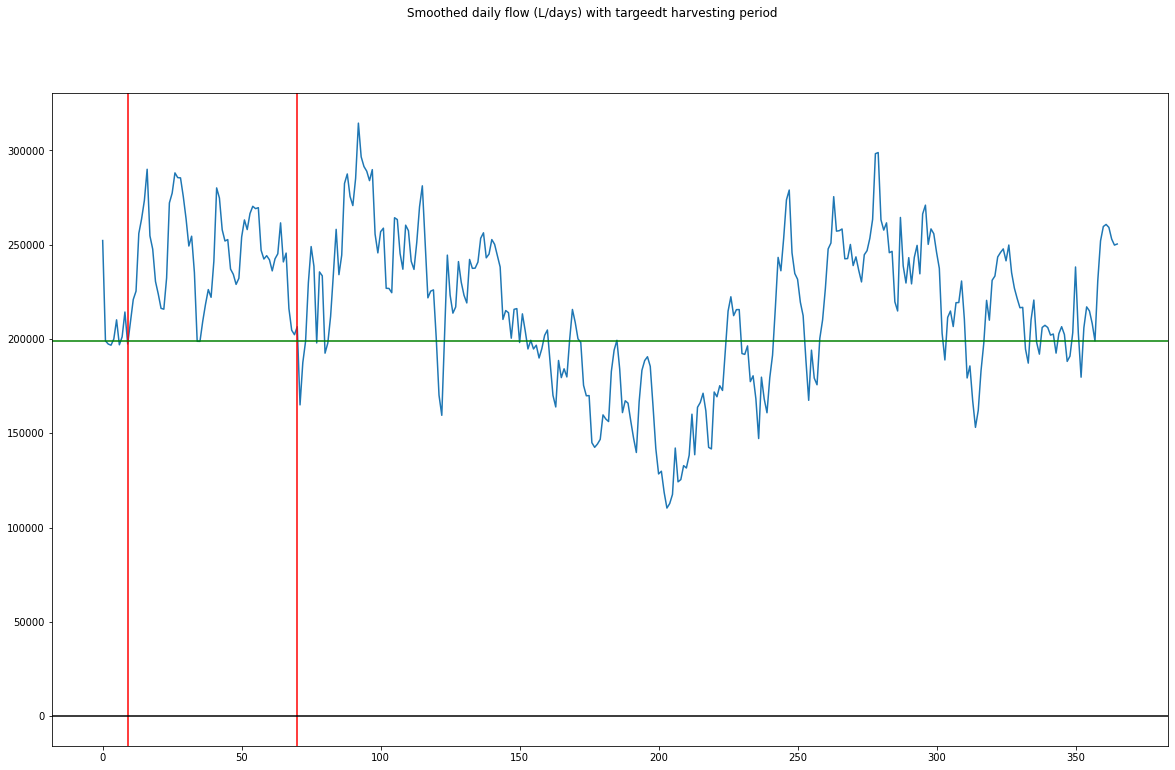

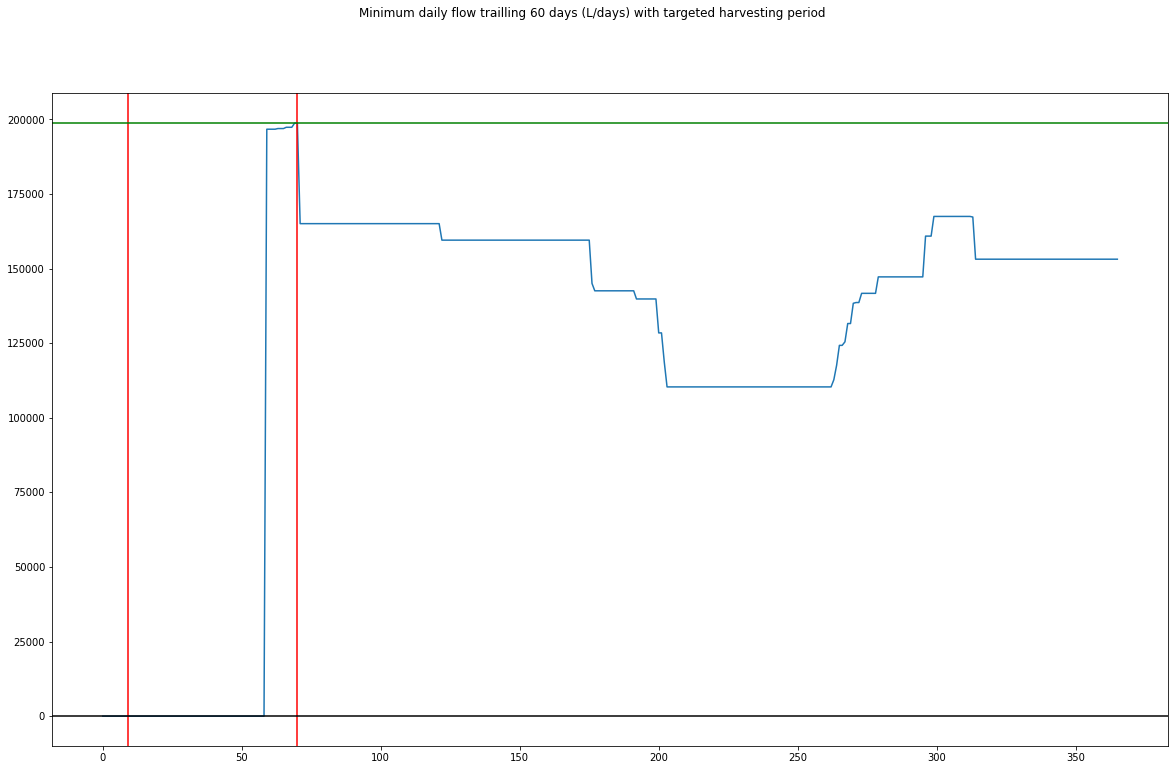

In [23]:
find_best_harvesting_period(compute_flow_rate_over_a_year(10, current_location, 0.15))